In [26]:
#reading relevant packages
import pandas as pd
import folium
import geopandas as gpd
import os
import fiona
from shapely.geometry import shape
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import gaussian_kde
import requests
import tempfile
import pandas as pd
import io
import json
import plotly.express as px
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots

### (portfolio) Reading basemap SP

In [ ]:
### reading shapefile from url 
url = "https://github.com/yantoniassi1/yantoniassi1.github.io/raw/main/ProjectData/SIRGAS_SHP_distrito.zip"

# Fetch the zip file
response = requests.get(url)
if response.status_code == 200:
    with tempfile.NamedTemporaryFile(suffix=".zip") as tmp_zip:
        tmp_zip.write(response.content)
        tmp_zip.seek(0)  # Go back to the beginning of the file
        
        # Read the shapefile from the temporary zip file
        gdf_districts = gpd.read_file(f"zip://{tmp_zip.name}")
        
        # Display the first rows of the GeoDataFrame
        print(gdf.head())
else:
    print("Failed to download the zip file. HTTP status code:", response.status_code)


In [19]:
#set crs
gdf_districts.crs = "EPSG:31983"
gdf_districts = gdf_districts.to_crs("EPSG:4326")

print(gdf_districts.crs)

EPSG:4326


In [21]:
geojson_path = "SIRGAS_SHP_distritcs.json"
gdf_districts.to_file(geojson_path, driver="GeoJSON")
print(f"GeoJSON saved as {geojson_path}")

GeoJSON saved as SIRGAS_SHP_distritcs.json


### (portfolio) Reading Hospitals points

In [25]:
# reading shapefile from url 
url = "https://github.com/yantoniassi1/yantoniassi1.github.io/raw/main/ProjectData/loc_geosampa_cleaned.zip"

# Fetch the zip file
response = requests.get(url)
if response.status_code == 200:
    with tempfile.NamedTemporaryFile(suffix=".zip") as tmp_zip:
        tmp_zip.write(response.content)
        tmp_zip.seek(0)  # Go back to the beginning of the file
        
        # Read the shapefile from the temporary zip file
        gdf_hosps = gpd.read_file(f"zip://{tmp_zip.name}")
        
        # Display the first rows of the GeoDataFrame
        print(gdf.head())
else:
    print("Failed to download the zip file. HTTP status code:", response.status_code)

       ds_nome ds_codigo ds_cd_sub        ds_subpref ds_sigla    ds_areamt  \
0     MANDAQUI        51        05  SANTANA-TUCURUVI      MAN  13249456.11   
1        MOEMA        32        12      VILA MARIANA      MOE   9079516.47   
2  ARTUR ALVIM         5        21             PENHA      AAL   6505750.23   
3     IGUATEMI        33        30        SAO MATEUS      IGU  19434636.54   
4   ITAIM BIBI        35        11         PINHEIROS      IBI  10026327.68   

   ds_areakm                                           geometry  
0     13.249  POLYGON ((333079.583 7408102.398, 333077.161 7...  
1      9.080  POLYGON ((331290.13 7392111.284, 331324.217 73...  
2      6.506  POLYGON ((349420.638 7397694.618, 349423.468 7...  
3     19.435  POLYGON ((350874.784 7389641.837, 350875.63 73...  
4     10.026  POLYGON ((327871.085 7386152.364, 327865.295 7...  


In [44]:
# Check the CRS of both GeoDataFrames
print("Districts CRS:", gdf_districts.crs)
print("Hospitals CRS:", gdf_hosps.crs)

if gdf_districts.crs != gdf_hosps.crs:
    gdf_hosps = gdf_hosps.to_crs(gdf_districts.crs)

Districts CRS: EPSG:4326
Hospitals CRS: EPSG:4326


In [42]:
#save to geojson
geojson_path = "loc_healthfacilities.json"
gdf_hosps.to_file(geojson_path, driver="GeoJSON")
print(f"GeoJSON saved as {geojson_path}")

GeoJSON saved as loc_healthfacilities.json


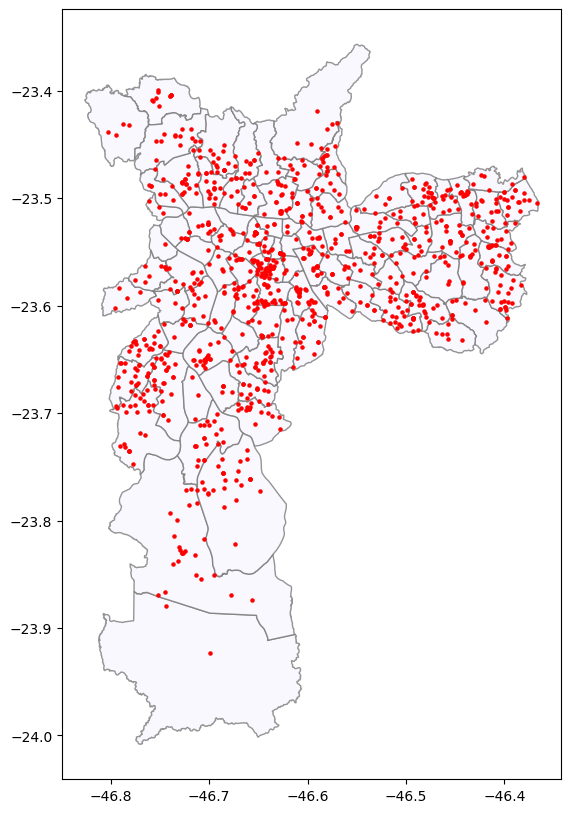

In [43]:
# Plot the basemap
ax = gdf_districts.plot(color='#F8F7FF', edgecolor='#7C7A7A', alpha=0.8, figsize=(10, 10))

# Overlay the points
gdf_hosps.plot(ax=ax, color='red', markersize=5)

# Show the plot
plt.show()

In [46]:
#value counts DEPADM	in gdf_hosps
gdf_hosps["DEPADM"].value_counts()

DEPADM
Municipal    882
Privado      165
Estadual      41
Federal        2
Name: count, dtype: int64

## Viz 2: dot plot or map showing healthcare expenditure 


#### Reading shapepefile of brazil

In [59]:
# Load the shapefile
bra_states = gpd.read_file('PortfolioData/BR_UF_2023/BR_UF_2023.shp')

# Display the first few rows
bra_states.head()

#turn CD_UF into numeric
bra_states['CD_UF'] = pd.to_numeric(bra_states['CD_UF'])

Text(0.5, 1.0, 'Brazil States')

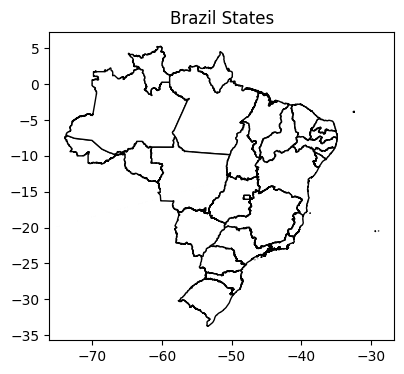

In [17]:
#plot the map
fig, ax = plt.subplots(figsize=(6, 4))
bra_states.plot(ax=ax, edgecolor='black', color='white')
plt.title('Brazil States')

#### Reading dataset IEPS with health expense data

In [60]:
#read expenses_timeseries_UF.csv
hexp_UF = pd.read_csv('ProjectData/expenses_timeseries_UF.csv')

#rename id_estado to CD_UF
hexp_UF = hexp_UF.rename(columns={"id_estado": "CD_UF"})

# Drop rows with NA in desp_tot_saude_pc_mun or desp_recp_saude_pc_mun
hexp_UF = hexp_UF.dropna(subset=['desp_tot_saude_pc_mun', 'desp_recp_saude_pc_mun'])

# Columns to process
columns_to_process = ['desp_tot_saude_pc_mun', 'desp_recp_saude_pc_mun']

# Replace ',' with '.', convert to numeric, and round to no decimals
hexp_UF[columns_to_process] = hexp_UF[columns_to_process].apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce').round(0))

#turn ano into date and keep only year
hexp_UF['ano'] = pd.to_datetime(hexp_UF['ano'], format='%Y')
hexp_UF['ano'] = hexp_UF['ano'].dt.year

#### Merging and plotting

In [61]:
#merge hexp_UF with bra_states
hexp_UF_geo = pd.merge(hexp_UF, bra_states, on='CD_UF')

#turn into geoDataFrame
hexp_UF_geo = gpd.GeoDataFrame(hexp_UF_geo, geometry='geometry')

#save to geojson
#hexp_UF_geo.to_file('hexp_UF_geo.geojson', driver='GeoJSON')

In [64]:
#drop rows with NA
hexp_UF_geo = hexp_UF_geo.dropna()

In [65]:
#drop rows with NA
hexp_UF_geo = hexp_UF_geo.dropna()

# Deduplicate geometries by state
hexp_UF_unique = hexp_UF_geo.drop_duplicates(subset='CD_UF').copy()

# Create a separate DataFrame for yearly data
yearly_hexp_UF = hexp_UF_geo[['CD_UF', 'ano', 'desp_tot_saude_pc_mun', 'desp_recp_saude_pc_mun']]

#rename ano to year
yearly_hexp_UF = yearly_hexp_UF.rename(columns={"ano": "year"})

In [66]:
# Save simplified geometry GeoJSON
hexp_UF_unique.to_file('hexp_UF_unique.geojson', driver='GeoJSON')

# Save yearly data as CSV for reference
yearly_hexp_UF.to_csv('yearly_hexp_UF.csv', index=False)

### Plotting

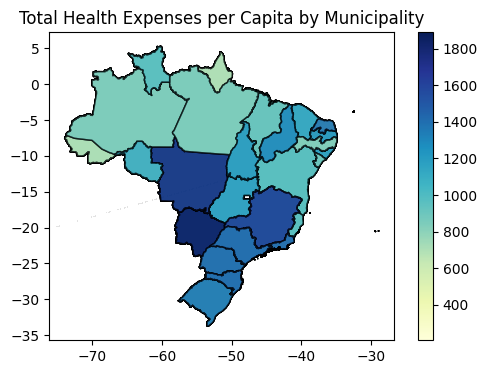

In [30]:
hexp_UF_geo = gpd.GeoDataFrame(hexp_UF_geo, geometry='geometry')

# Plot the map
fig, ax = plt.subplots(figsize=(6, 4))
hexp_UF_geo.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.6, column='desp_tot_saude_pc_mun', legend=True, cmap='YlGnBu')

# Set the title
plt.title('Total Health Expenses per Capita by Municipality')

# Show the plot
plt.show()

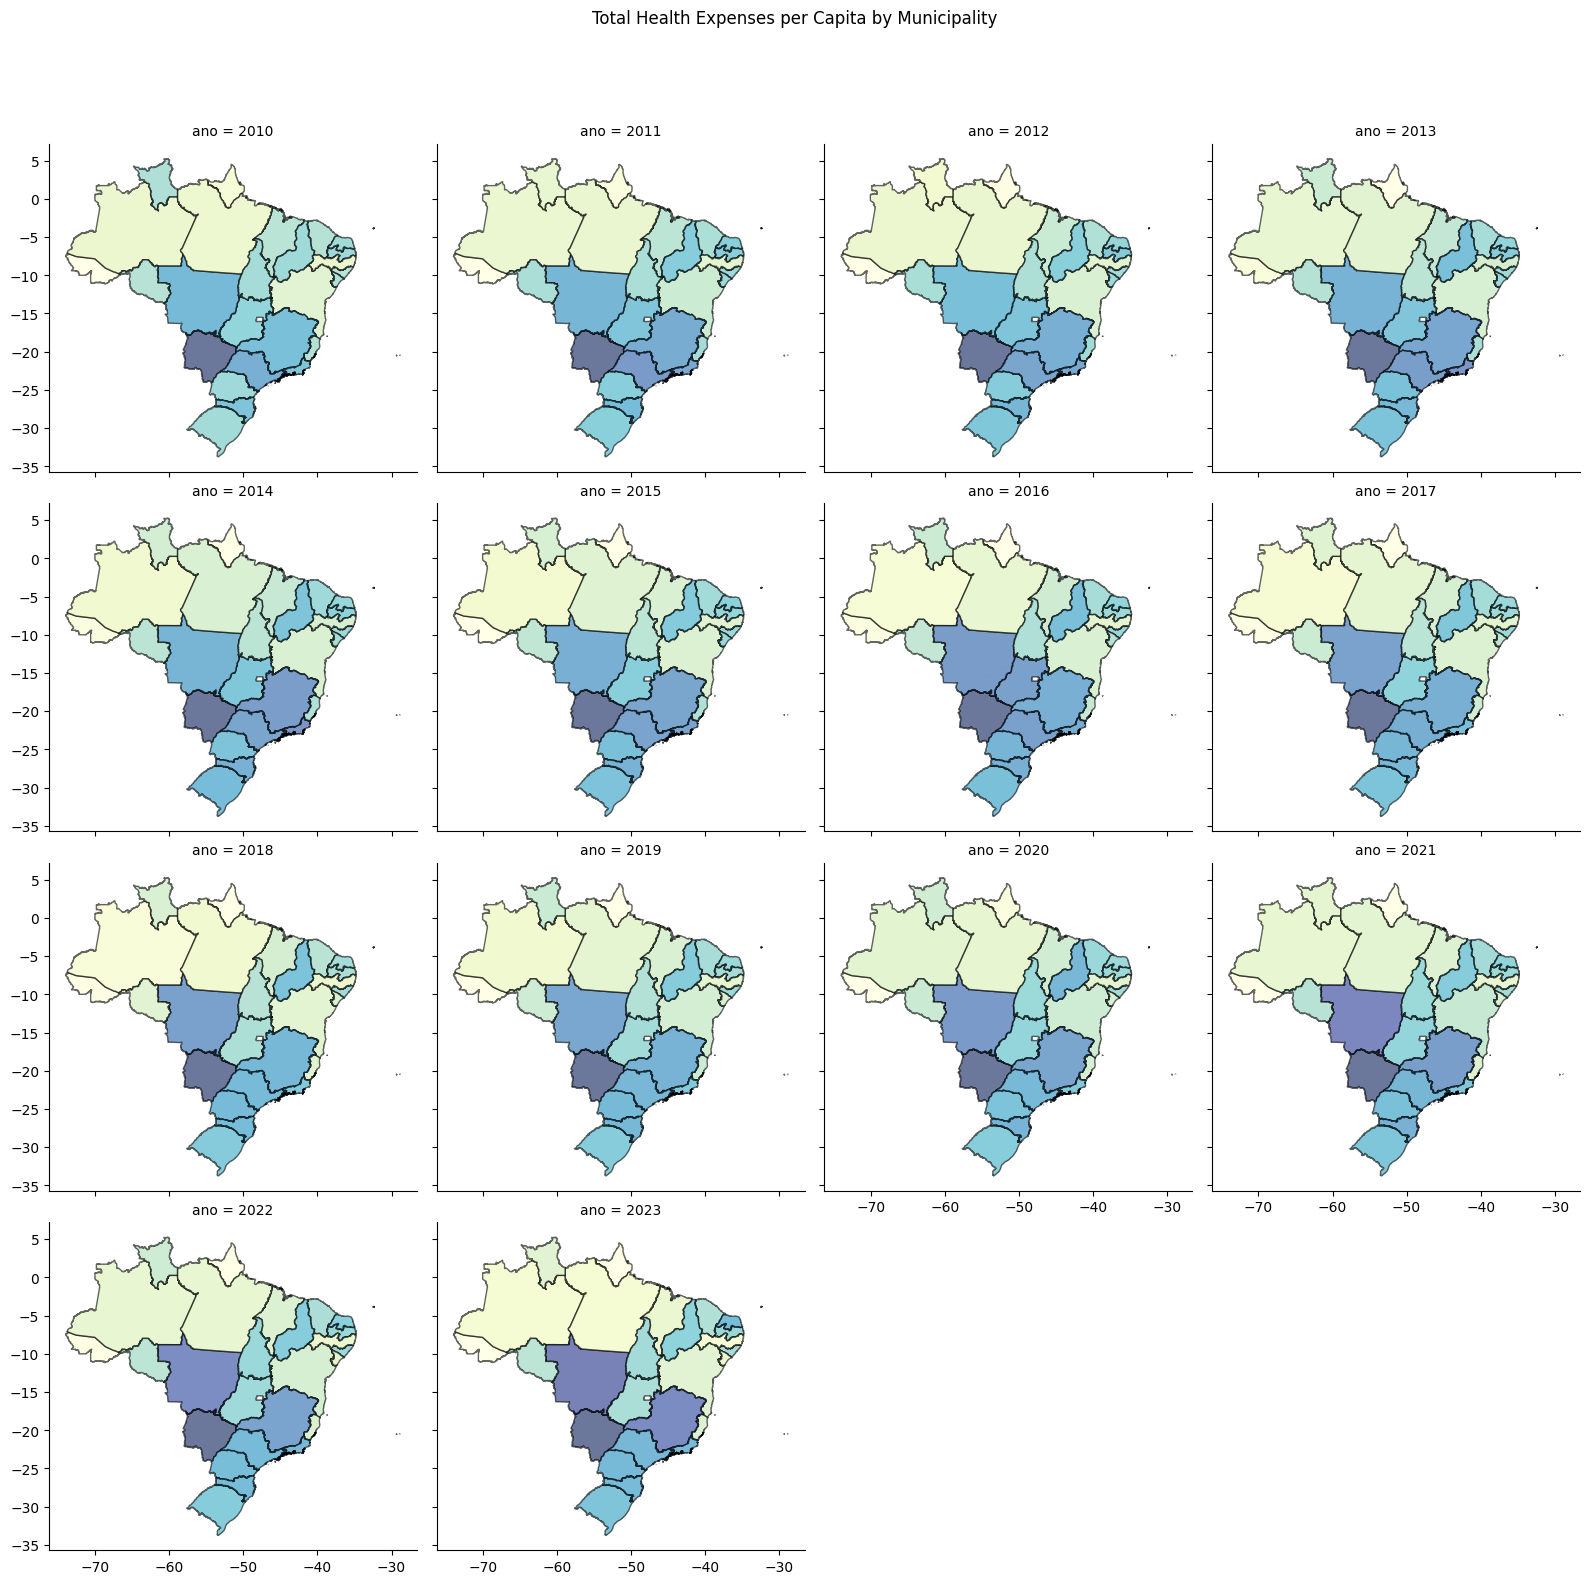

In [47]:
# Create a FacetGrid with seaborn
g = sns.FacetGrid(hexp_UF_geo, col="ano", col_wrap=4, height=4)

# Define a plotting function
def plot_map(data, **kwargs):
    ax = plt.gca()
    data.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.6, column='desp_tot_saude_pc_mun', legend=False, cmap='YlGnBu')

# Map the plotting function to the FacetGrid
g.map_dataframe(plot_map)

# Add a title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Health Expenses per Capita by Municipality')

# Show the plot
plt.show()

In [ ]:
# Load CSV
csv_data = pd.read_csv('ProjectData/yearly_hexp_UF.csv')
print(csv_data.head())

# Load GeoJSON
geo_data = gpd.read_file('ProjectData/hexp_UF_unique.geojson')
print(geo_data[['CD_UF']].head())

   CD_UF  year  desp_tot_saude_pc_mun  desp_recp_saude_pc_mun
0     12  2010                  205.0                   114.0
1     27  2010                  329.0                   125.0
2     13  2010                  264.0                   164.0
3     16  2010                  234.0                   111.0
4     29  2010                  286.0                   121.0
   CD_UF
0     12
1     27
2     13
3     16
4     29
set()
{53}


In [57]:
# Check unique state IDs
print(set(csv_data['CD_UF']).difference(set(geo_data['CD_UF'])))

set()


In [58]:
print(set(geo_data['CD_UF']).difference(set(csv_data['CD_UF'])))

{53}


## Viz 3: Treemap Expenses per Subarea

In [142]:
#read from github https://github.com/yantoniassi1/yantoniassi1.github.io/blob/main/ProjectData/exp_subarea_UF_2023.csv
url = "https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/ProjectData/exp_subarea_UF_2023.csv"

# Fetch the CSV content
response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses

# Read the CSV content into a pandas DataFrame
exp_subarea_UF = pd.read_csv(io.StringIO(response.text))

#rename the value 

In [143]:
#split CD_UF into two columns
exp_subarea_UF[['CD_UF', 'NAME_UF']] = exp_subarea_UF['CD_UF'].str.split(' ', n=1, expand=True)

#turn , into .
exp_subarea_UF = exp_subarea_UF.apply(lambda x: x.str.replace(',', '.'))

#turn all expect NAME_UF into numeric
exp_subarea_UF = exp_subarea_UF.apply(pd.to_numeric, errors='ignore')

/var/folders/91/0p_7xl4n1wzcnkf1483hnvfm0000gn/T/ipykernel_63050/694057519.py:11: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [144]:
# Convert the dataset from wide to long format
df_long = exp_subarea_UF.melt(
    id_vars=['CD_UF', 'NAME_UF'],  # Columns to keep
    var_name='Expense_Type',  # New column name for expense types
    value_name='Value'  # New column name for values
)


# Create a mapping dictionary for the larger groups
group_mapping = {
    '02': 'Diagnostic Procedures',
    '03': 'Clinical Procedures',
    '04': 'Surgical Procedures',
    '05': 'Organ, Tissue, and Cell Transplants'
}

# Add a new column for the larger group
df_long['Group'] = df_long['Expense_Type'].str[:2].map(group_mapping)

In [147]:
# Remove the numbers from the 'Expense_Type' column
df_long['Expense_Type'] = df_long['Expense_Type'].str.replace(r'^\d+\s+', '', regex=True)

  CD_UF   NAME_UF            Expense_Type      Value                  Group
0    11  Rondônia  Collection of material   51875.92  Diagnostic Procedures
1    12      Acre  Collection of material   23075.46  Diagnostic Procedures
2    13  Amazonas  Collection of material   48060.56  Diagnostic Procedures
3    14   Roraima  Collection of material    7559.06  Diagnostic Procedures
4    15      Pará  Collection of material  101717.37  Diagnostic Procedures


### Plotting a treemap

In [40]:
# Filter the DataFrame to include only the 'Total' row in the 'CD_UF' column
total_row = exp_subarea_UF[exp_subarea_UF['CD_UF'] == 'Total']

# Melt the DataFrame to long format
melted_total_row = total_row.melt(id_vars=['CD_UF', 'NAME_UF'], var_name='Subarea', value_name='Value')

# Create a mapping dictionary for the larger groups
group_mapping = {
    '02': 'Diagnostic Procedures',
    '03': 'Clinical Procedures',
    '04': 'Surgical Procedures',
    '05': 'Organ, Tissue, and Cell Transplants'
}

# Add a new column for the larger group
melted_total_row['Group'] = melted_total_row['Subarea'].str[:2].map(group_mapping)

In [59]:
#save dataset 
#melted_total_row.to_csv('exp_subarea_total_2023.csv', index=False)

#head
melted_total_row.head()

#delete rows with CD_UF and NAME_UF
melted_total_row = melted_total_row.drop(['CD_UF', 'NAME_UF'], axis=1)

In [61]:
#save to csv
#melted_total_row.to_csv('exp_subarea_total_2023.csv', index=False)

## Viz 4: Correlation

### Data at the UF level - 2023

In [181]:
#read url: https://github.com/yantoniassi1/yantoniassi1.github.io/blob/main/ProjectData/Allindicators_UF_2023.csv
url = "https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/ProjectData/Allindicators_UF_2023.csv"

# Fetch the CSV content
response = requests.get(url)

# Read the CSV content into a pandas DataFrame
all_indicators_UF = pd.read_csv(io.StringIO(response.text))

In [ ]:
#delete id estado = 53 (distrito federal)
all_indicators_UF = all_indicators_UF[all_indicators_UF['id_estado'] != 53]

# Ensure all columns are of string type before replacing commas
all_indicators_UF = all_indicators_UF.applymap(lambda x: str(x) if not pd.isna(x) else x)

# Turn , into .
all_indicators_UF = all_indicators_UF.apply(lambda x: x.str.replace(',', '.'))

#turn all columns from cob_ab to desp_tot_saude_pc_mun into numeric
all_indicators_UF = all_indicators_UF.apply(pd.to_numeric, errors='ignore')

In [184]:
#head
all_indicators_UF.head()

id_estado estado_abrev    estado   ano regiao_geo     cob_ab  \
0         12           AC      Acre  2023      Norte  91.873791   
1         27           AL   Alagoas  2023   Nordeste  87.782617   
2         13           AM  Amazonas  2023      Norte  84.550716   
3         16           AP     Amapá  2023      Norte  99.816970   
4         29           BA     Bahia  2023   Nordeste  90.924424   

   pct_prenatal_adeq  tx_mort_evit     tx_mort  tx_mort_inf_ibge      tx_hosp  \
0          52.116513    112.889118  518.422492         13.685761  6838.285435   
1          76.882391    151.965528  717.847685         13.671756  5241.068228   
2          58.621330    117.312379  535.389953         15.105758  5460.657858   
3          53.893888    123.201215  553.178905         21.810294  7410.062432   
4          68.491891    116.026262  738.422866         13.574239  6340.211515   

   tx_leito_sus  tx_med_ch  tx_enf_ch  desp_tot_saude_pc_mun  
0    181.441848   2.039775   1.874327             776.965550  
1    179.717702   2.282121   1.924164            1233.560535  
2    156.839345   1.880531   2.056068             897.549463  
3    192.024902   1.656879   2.705725             768.586795  
4    185.332295   2.188405   1.989665            1028.417552

In [187]:
#plot barplot of desp_tot_saude_pc_mun using plotly interactive
fig = px.bar(all_indicators_UF, x='estado_abrev', y='desp_tot_saude_pc_mun', title='Total Health Expenses per Capita by State')
fig.show()

In [194]:
#plotting correlation of desp_tot_saude_pc_mun and pct_prenatal_adeq with a regression line
import plotly.express as px

fig = px.scatter(all_indicators_UF, x='desp_tot_saude_pc_mun', y='pct_prenatal_adeq', title='Total Health Expenses per Capita vs. Adequate Prenatal Care', trendline='ols')
fig.show()

### Data at the municipality level - 2023

In [256]:
#read https://github.com/yantoniassi1/yantoniassi1.github.io/blob/main/ProjectData/Allindicators_MUN_2023.csv
url = "https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/ProjectData/Allindicators_MUN_2023.csv"

# Fetch the CSV content
response = requests.get(url)

# Read the CSV content into a pandas DataFrame
all_indicators_MUN = pd.read_csv(io.StringIO(response.text))

In [257]:
# Ensure all columns are of string type before replacing commas
all_indicators_MUN = all_indicators_MUN.applymap(lambda x: str(x) if not pd.isna(x) else x)

# Turn , into .
all_indicators_MUN = all_indicators_MUN.apply(lambda x: x.str.replace(',', '.'))

#Convert to numeric
all_indicators_MUN = all_indicators_MUN.apply(pd.to_numeric, errors='ignore')

/var/folders/91/0p_7xl4n1wzcnkf1483hnvfm0000gn/T/ipykernel_63050/2381909437.py:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/var/folders/91/0p_7xl4n1wzcnkf1483hnvfm0000gn/T/ipykernel_63050/2381909437.py:8: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [258]:
#turn desp_tot_saude_pc_mun into numeric, coercing errors to NaN
all_indicators_MUN['desp_tot_saude_pc_mun'] = pd.to_numeric(all_indicators_MUN['desp_tot_saude_pc_mun'], errors='coerce')

# Drop rows with NaN values in 'desp_tot_saude_pc_mun'
all_indicators_MUN = all_indicators_MUN.dropna(subset=['desp_tot_saude_pc_mun'])

In [265]:
#head
all_indicators_MUN.head()

ano regiao_geo  id_munic_7  codmun  capital       nomemun  id_estado  \
0  2023      Norte     1200013  120001        0    Acrelândia         12   
1  2023      Norte     1200054  120005        0  Assis Brasil         12   
2  2023      Norte     1200104  120010        0     Brasiléia         12   
3  2023      Norte     1200138  120013        0        Bujari         12   
4  2023      Norte     1200179  120017        0      Capixaba         12   

  estado_abrev estado  regiao  ...     tx_mort  tx_mort_inf_ibge  \
0           AC   Acre   12002  ...  435.061693                     
1           AC   Acre   12001  ...  444.444444                     
2           AC   Acre   12001  ...  619.230769                     
3           AC   Acre   12002  ...  456.762406                     
4           AC   Acre   12002  ...  481.139338                     

        tx_hosp  tx_leito_sus  tx_med_ch  tx_enf_ch  desp_tot_saude_pc_mun  \
0   5113.757935     42.792953   0.969974   0.838029                 933.57   
1  11728.395062    148.148148   1.481481   1.679012                1040.51   
2   8200.000000    284.615385   2.160577   2.632692                 834.12   
3   2771.541380      0.000000   0.696756   0.619339                1021.57   
4   4513.086990      0.000000   0.721709   0.962279                 815.80   

  exp_vida  pct_san_adeq  ideb_9ano  
0                                    
1                                    
2                                    
3                                    
4                                    

[5 rows x 26 columns]

In [269]:
#colum types
all_indicators_MUN.dtypes

ano                        int64
regiao_geo                object
id_munic_7                 int64
codmun                     int64
capital                    int64
nomemun                   object
id_estado                  int64
estado_abrev              object
estado                    object
regiao                     int64
no_regiao                 object
macrorregiao               int64
no_macro                  object
cob_ab                   float64
pct_prenatal_adeq        float64
tx_mort_evit             float64
tx_mort                  float64
tx_mort_inf_ibge          object
tx_hosp                  float64
tx_leito_sus             float64
tx_med_ch                float64
tx_enf_ch                float64
desp_tot_saude_pc_mun    float64
exp_vida                  object
pct_san_adeq              object
ideb_9ano                 object
dtype: object

In [261]:
#plot barplot of the 20 with hgihest desp_tot_saude_pc_mun
top_20_mun = all_indicators_MUN.nlargest(20, 'desp_tot_saude_pc_mun')
fig = px.bar(top_20_mun, x='nomemun', y='desp_tot_saude_pc_mun', title='Top 20 Municipalities by Total Health Expenses per Capita', color_discrete_sequence=['green'])
fig.show()

In [260]:
#now the 20 with the lowest desp_tot_saude_pc_mun
bottom_20_mun = all_indicators_MUN.nsmallest(20, 'desp_tot_saude_pc_mun')
fig = px.bar(bottom_20_mun, x='nomemun', y='desp_tot_saude_pc_mun', title='Bottom 20 Municipalities by Total Health Expenses per Capita')
fig.show()

In [ ]:
#turn into numeric pct_prenatal_adeq
all_indicators_MUN['pct_prenatal_adeq'] = pd.to_numeric(all_indicators_MUN['pct_prenatal_adeq'], errors='coerce')

# Filter for tx_leito_sus > 0
filtered_data = all_indicators_MUN[all_indicators_MUN['tx_leito_sus'] > 0]

In [290]:
# Variables to plot
variables = ['tx_leito_sus', 'pct_prenatal_adeq', 'tx_mort', 'tx_mort_evit', 'tx_hosp', 'tx_med_ch', 'tx_enf_ch']

# Create a subplot grid
fig = make_subplots(rows=2, cols=4, subplot_titles=variables)

# Add each scatter plot with a regression line to the grid
for i, var in enumerate(variables):
    row = i // 4 + 1
    col = i % 4 + 1
    
    # Drop rows with NaN values in the columns used for plotting
    filtered_data = all_indicators_MUN.dropna(subset=['desp_tot_saude_pc_mun', var])
    
    # Scatter plot
    scatter = px.scatter(filtered_data, x='desp_tot_saude_pc_mun', y=var, color='regiao_geo', opacity=0.6)
    
    # Calculate the regression line
    X = filtered_data['desp_tot_saude_pc_mun'].values.reshape(-1, 1)
    y = filtered_data[var].values
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    
    # Add scatter plot to subplot
    for trace in scatter.data:
        fig.add_trace(trace, row=row, col=col)
    
    # Add regression line to subplot
    fig.add_trace(go.Scatter(x=filtered_data['desp_tot_saude_pc_mun'], y=y_pred,
                             mode='lines', name='Regression Line', line=dict(color='black')), row=row, col=col)

# Update layout
fig.update_layout(height=800, width=1200, title_text="Scatter Plots with Regression Lines")
fig.show()

In [324]:
all_indicators_MUN_5000.head()

ano regiao_geo  id_munic_7  codmun  capital                   nomemun  \
0  2023      Norte     1501204  150120        0                     Baião   
1  2023   Nordeste     2401453  240145        0                   Baraúna   
2  2023      Norte     1600212  160021        0                    Cutias   
3  2023   Nordeste     2105963  210596        0  Lagoa Grande do Maranhão   
4  2023      Norte     1722081  172208        0              Wanderlândia   

   id_estado estado_abrev               estado  regiao  ...     tx_mort  \
0         15           PA                 Pará   15011  ...  288.530431   
1         24           RN  Rio Grande do Norte   24002  ...  516.479025   
2         16           AP                Amapá   16001  ...  358.663977   
3         21           MA             Maranhão   21010  ...  508.281483   
4         17           TO            Tocantins   17001  ...  693.784452   

   tx_mort_inf_ibge      tx_hosp  tx_leito_sus  tx_med_ch  tx_enf_ch  \
0                    5640.866753     63.902713   0.265777   0.445383   
1                    5751.867127     78.029205   1.045963   1.207595   
2                    2757.229321      0.000000   0.414705   2.364941   
3                    6309.701166    166.506003   0.810621   1.042853   
4                    5350.693784      0.000000   0.591618   1.615662   

   desp_tot_saude_pc_mun exp_vida  pct_san_adeq  ideb_9ano  
0                 183.98      NaN                           
1                 200.66      NaN                           
2                 228.02      NaN                           
3                 247.10      NaN                           
4                 304.99      NaN                           

[5 rows x 26 columns]

In [339]:
import altair as alt

# Define the URL for the data source
url = "https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/ProjectData/all_indicators_MUN_5000.csv"

# Variable Mapping for Dropdown Display Names
variable_labels = {
    'tx_leito_sus': 'Number of Hospital Beds (per 100,000 Hab.)',
    'tx_med_ch': 'Doctors (Standardized by Workload, per 1,000 Hab.)',
    'tx_enf_ch': 'Nurses (Standardized by Workload, per 1,000 Hab.)',
    'tx_hosp': 'Hospitalizations (per 100,000 Hab.)',
    'tx_mort_evit': 'Avoidable Cause Mortality (per 100,000 Hab.)',
    'tx_mort': 'Gross Mortality (per 100,000 Hab.)'
}

# Dropdown Parameter for Variable Selection
variable_dropdown = alt.param(
    name='variable_selection',
    bind=alt.binding_select(
        options=list(variable_labels.keys()),
        labels=list(variable_labels.values()),
        name='Select Indicator: '
    ),
    value='tx_mort'
)

# Selection for Interactive Legend Filtering
region_selection = alt.selection_multi(
    fields=['regiao_geo'],
    bind='legend'
)

# Scatter Plot with Dropdown and Interactive Legend
scatter = alt.Chart(url).mark_circle(size=60, opacity=0.8).encode(
    x=alt.X('desp_tot_saude_pc_mun:Q', title='Total Health Expenditure per Capita (Municipality)'),
    y=alt.Y('value:Q', title='Selected Variable'),
    color=alt.Color('regiao_geo:N', title='Geographic Region'),
    tooltip=[
        alt.Tooltip('nomemun:N', title='Municipality'),
        alt.Tooltip('desp_tot_saude_pc_mun:Q', title='Health Expenditure (R$ per Capita)'),
        alt.Tooltip('value:Q', title='Variable Value'),
        alt.Tooltip('regiao_geo:N', title='Geographic Region')
    ],
    opacity=alt.condition(region_selection, alt.value(0.9), alt.value(0.2))
).transform_fold(
    list(variable_labels.keys()),
    as_=['variable', 'value']
).transform_filter(
    alt.datum.variable == variable_dropdown
).add_params(
    variable_dropdown
).add_selection(
    region_selection
)

# Regression Line
regression_line = alt.Chart(url).transform_fold(
    list(variable_labels.keys()),
    as_=['variable', 'value']
).transform_filter(
    alt.datum.variable == variable_dropdown
).transform_regression(
    'desp_tot_saude_pc_mun', 'value', method='linear'
).mark_line(color='black').encode(
    x='desp_tot_saude_pc_mun:Q',
    y='value:Q'
)

# Final Combined Chart with Larger Title
final_chart = (scatter + regression_line).properties(
    title=alt.TitleParams(
        text='Correlation Between Health Outcomes and Health Expenditure per Capita',
        fontSize=20,
        fontWeight='bold',
        anchor='middle'
    ),
    width=900,
    height=600
)

/var/folders/91/0p_7xl4n1wzcnkf1483hnvfm0000gn/T/ipykernel_63050/2303659214.py:28: AltairDeprecationWarning:


Deprecated since `altair=5.0.0`. Use selection_point instead.

/var/folders/91/0p_7xl4n1wzcnkf1483hnvfm0000gn/T/ipykernel_63050/2303659214.py:52: AltairDeprecationWarning:


Deprecated since `altair=5.0.0`. Use add_params instead.



In [340]:
#show
final_chart.show()

alt.LayerChart(...)

In [341]:
#save jsom
final_chart.save('v4_scatter_dropdown.json')